In [1]:
from collections import deque
import random
import gym
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class WindyGridWorld(gym.Env):
    def __init__(self,
                 height=7,
                 width=10,
                 action_space=4,
                 step_reward=-1,
                 end_reward=1,
                 start_state=None,
                 end_state=None,
                 crosswind=None,
                 ):
        super(WindyGridWorld, self).__init__()

        if start_state is None:
            start_state = (3, 0)
        if end_state is None:
            end_state = (3, 7)
        if crosswind is None:
            crosswind = [0, 0, 0, 1, 1, 1, 2, 2, 1, 0]

        self.height = height
        self.width = width
        self.action_space = gym.spaces.Discrete(action_space)
        self.observation_space = gym.spaces.Tuple((
            gym.spaces.Discrete(height),
            gym.spaces.Discrete(width)
        ))
        self.step_reward = step_reward
        self.end_reward = end_reward
        self.start_state = start_state
        self.end_state = end_state
        self.current_state = self.start_state
        self.crosswind = crosswind
        self.moves = {
            0: (1, 0),  # up
            1: (-1, 0),  # down
            2: (0, 1),  # right
            3: (0, -1),  # left
        }

    def step(self, action):
        y, x = self.moves[action]

        self.current_state = self.current_state[0] + y, self.current_state[1] + x
        self.current_state = max(self.current_state[1], 0), max(self.current_state[0], 0)
        self.current_state = min(self.current_state[1], self.height - 1), min(self.current_state[0], self.width - 1)

        crosswind_strength = self.crosswind[self.current_state[1]]
        self.current_state = self.current_state[0] + crosswind_strength, self.current_state[1]
        self.current_state = min(self.current_state[0], self.height - 1), self.current_state[1]

        if self.current_state == self.end_state:
            return self.current_state, self.end_reward, True
        return self.current_state, self.step_reward, False

    def reset(self, seed=None, options=None):
        self.current_state = self.start_state
        return self.current_state

    def render(self):
        grid = [['.' for _ in range(self.width)] for _ in range(self.height)]

        grid[self.end_state[0]][self.end_state[1]] = 'G'
        grid[self.current_state[0]][self.current_state[1]] = 'A'

        print('\n'.join([''.join(row) for row in grid[::-1]]))
        print('\n')

In [3]:
class DeepQLearningNetwork(nn.Module):
    def __init__(self,
                 state_dims,
                 action_dims,
                 hidden1=128,
                 hidden2=128,
                 ):
        super(DeepQLearningNetwork, self).__init__()
        self.fx1 = nn.Linear(state_dims, hidden1)
        self.fx2 = nn.Linear(hidden1, hidden2)
        self.fx3 = nn.Linear(hidden2, action_dims)

    def forward(self, x):
        x = torch.relu(self.fx1(x))
        x = torch.relu(self.fx2(x))
        return self.fx3(x)

In [13]:
def train(episodes,
          gamma=0.9,
          epsilon_start=1.0,
          epsilon_end=0.01,
          epsilon_decay=0.99,
          batch_size=1024,
          learning_rate=1e-5,
          memory_size=10000,
          hidden1=128,
          hidden2=128,
          state_dims=2,
          action_dims=4,
          ):

    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

    env = WindyGridWorld()

    policy_dqn = DeepQLearningNetwork(state_dims, action_dims, hidden1=hidden1, hidden2=hidden2).to(device)
    target_dqn = DeepQLearningNetwork(state_dims, action_dims, hidden1=hidden1, hidden2=hidden2).to(device)
    target_dqn.load_state_dict(policy_dqn.state_dict())
    target_dqn.eval()
    loss_fn = nn.MSELoss()

    optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=learning_rate)
    memory = deque(maxlen=memory_size)
    epsilon = epsilon_start
    total_reward_record = []

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        loss = 0
        done = False

        while not done:
            if random.random() < epsilon:
                action = env.action_space.sample()
            else:
                state_tensor = torch.tensor(state, dtype=torch.float).to(device)
                with torch.no_grad():
                    action = torch.argmax(policy_dqn(state_tensor)).item()

            next_step = env.step(action)
            total_reward += next_step[1]

            memory.append((state, action, next_step[1], next_step[0], next_step[2]))

            state = next_step[0]
            done = next_step[2]

            if len(memory) > batch_size:
                batch = random.sample(memory, batch_size)
                states, actions, rewards, next_states, dones = zip(*batch)

                states = torch.tensor(states, dtype=torch.float).to(device)
                actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(device)
                rewards = torch.tensor(rewards, dtype=torch.long).to(device)
                next_states = torch.tensor(next_states, dtype=torch.float).to(device)
                dones = torch.tensor(dones, dtype=torch.long).to(device)

                q_value = policy_dqn(states).gather(1, actions)

                with torch.no_grad():
                    max_next_q_value = target_dqn(next_states).max(1)[0]
                    target_q_value = rewards + (gamma * max_next_q_value * (1 - dones))

                loss = loss_fn(q_value.squeeze(), target_q_value)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        epsilon = max(epsilon_end, epsilon_decay * epsilon)

        if episode % 10 == 0:
            target_dqn.load_state_dict(policy_dqn.state_dict())

        total_reward_record.append(total_reward)
        print(f'Episode: {episode + 1}, Total Reward: {total_reward}, Loss: {loss}')

    env.close()
    return total_reward_record

In [14]:
total_reward_record = train(500)

Episode: 1, Total Reward: -70981, Loss: 4.790151137967769e-07
Episode: 2, Total Reward: -55310, Loss: 5.82031952944817e-06
Episode: 3, Total Reward: -26594, Loss: 1.5160391058088862e-06
Episode: 4, Total Reward: -29197, Loss: 4.017576316073246e-07
Episode: 5, Total Reward: -19610, Loss: 1.3161318292986834e-06
Episode: 6, Total Reward: -13628, Loss: 1.4755634083485347e-06
Episode: 7, Total Reward: -890, Loss: 2.2296553652267903e-06
Episode: 8, Total Reward: -22055, Loss: 8.224490102293203e-07
Episode: 9, Total Reward: -22298, Loss: 1.4866437823002343e-06
Episode: 10, Total Reward: -1039, Loss: 2.433285590086598e-05
Episode: 11, Total Reward: -2485, Loss: 0.00017571284843143076
Episode: 12, Total Reward: -15880, Loss: 3.6803350667469203e-05
Episode: 13, Total Reward: -20594, Loss: 4.951119535689941e-06
Episode: 14, Total Reward: -41460, Loss: 2.7515316105564125e-06
Episode: 15, Total Reward: -8319, Loss: 0.005509076174348593
Episode: 16, Total Reward: -2585, Loss: 1.4960163753130473e-05


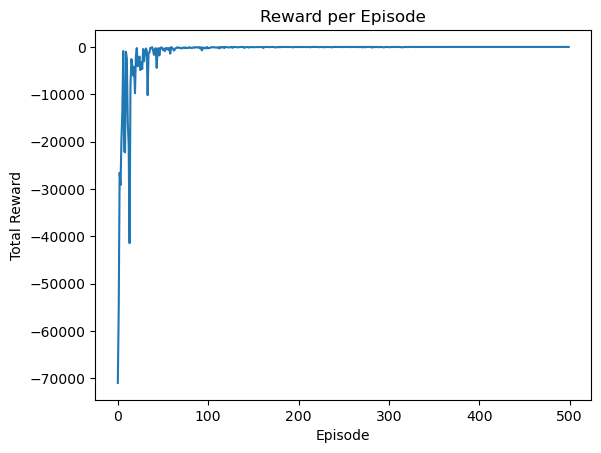

In [15]:
plt.plot(total_reward_record)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Reward per Episode')
plt.show()